In [2]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
sys.path

['C:\\Users\\Mechano_2',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\python37.zip',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\DLLs',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final',
 '',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Mechano_2\\.ipython',
 'C:\\Users\\Mechano_2\\PycharmProjects\\pro']

In [8]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mecha.fracture as fracture
import mecha.DIC as dic
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pickle

In [9]:
#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\Epoxy_ml\2021-06-04\0.5mmsec_1'

In [10]:
slice_x1 = 157
slice_x2 = 206
slice_y1 = 76
slice_y2 = 528
file_list = os.listdir(path+'/img')

result = []
for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path,'img', file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])

with open(path+'/ml_data.pkl','wb') as f:
    pickle.dump(result, f)
print('Save Done')





KeyboardInterrupt: 

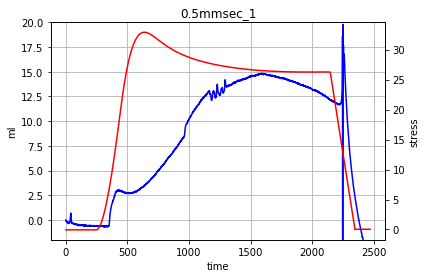

In [11]:
with open(path+'/ml_data.pkl','rb') as f:
    result = pickle.load(f)

result = result - result[0]
ml_avg = np.copy(result)
from scipy.signal import savgol_filter


tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*500/18
max_range = len(time)
# ml_avg[3545:] = ml_avg[3545:] + 1.4
stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
# ml_avg = savgol_filter(ml_avg[0:max_range],2001,1)
ml_avg =  ml_avg[0:max_range]
time = time[0:max_range]



fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.set_xlabel('time')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
ax.plot(time, ml_avg, color='b', label="Average Ml(Same mask)")
ax1.plot(time, stress, color='r', label=" stress")
ax.set_ylim(-2,20)
ax.grid()
plt.title('{}'.format(path.split('\\')[-1]))
plt.savefig(path+'/{}.png'.format(path.split('\\')[-1]), dpi=300, bbox_inches='tight',  pad_inches=0)

In [16]:

"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\Epoxy_ml\20210604\0.05mmsec_2\DIC_img\data'

for i=1:1:19
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""

dic.make_mask(path+'/DIC_img')

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\drawing.cpp:2403: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'cv::fillPoly'


In [12]:
image = dic.load_file(path+'/DIC_img')
ref = image[list(image.keys())[0]]
print(list(image.keys()))

['num_00001', 'num_00002', 'num_00003', 'num_00004', 'num_00005', 'num_00006', 'num_00007', 'num_00008', 'num_00009', 'num_00010', 'num_00011', 'num_00012', 'num_00013', 'num_00014', 'num_00015', 'num_00016', 'num_00017', 'num_00018', 'num_00019', 'num_00020', 'num_00021', 'num_00022', 'num_00023']


In [15]:
ref_xy_list = []
x_list=np.arange(170,180,3)
y_list=np.arange(490,580,50)
for xx in x_list:
    for yy in y_list:
        ref_xy_list.append([xx,yy])
# ref_xy_list = [[180,600]]

ratio = 1
scale_factor = 4
skip = 100

df = pd.DataFrame(columns=['image_name', 'voltage_strain','voltage_stress', 'DIC_eyy'])

for ref_x, ref_y in ref_xy_list:
    # for num in [12,,8,9,10,13,14,15,16,17,18,19,20,21,22]:
    for num in range(1,18+1):
        file_num = str(num)
        eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
        eyy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )

        image_name = int(list(image.keys())[num].split('_')[1])

        voltage_strain = strain[int(list(image.keys())[num].split('_')[1])+(num*skip)]
        voltage_stress = stress[int(list(image.keys())[num].split('_')[1])+(num*skip)]

        DIC_eyy = np.average(dic.find_zone(eyy))

        ml_average = ml_avg[int(list(image.keys())[num].split('_')[1])+(num*skip)]
        row = pd.Series([image_name, voltage_strain,voltage_stress, DIC_eyy ],
                    index=['image_name', 'voltage_strain','voltage_stress', 'DIC_eyy'])
        df = df.append(row, ignore_index=True)

IndexError: index 2506 is out of bounds for axis 0 with size 2471

616


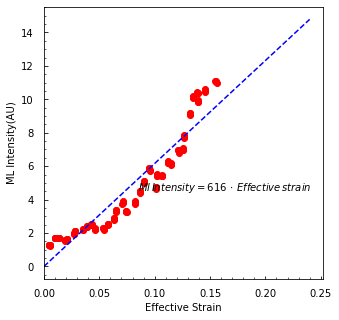

In [8]:

"""최소자승법"""
lms_list = []
for k in range(0,5000):
    i = k*0.1
    lms = np.sum(((i * df.local_ee) - df.local_ml)**2)
    lms_list.append(lms)
np.argmin(lms_list)

plt.rcParams["figure.figsize"] = (5,5)

plt.text(0.085,4.5,'$Ml\,Intensity=%d \,\cdot\, Effective\,strain$'%np.argmin(lms_list), fontsize='10')
plt.scatter(df.local_ee, df.local_ml, color='red',zorder=1)
plt.plot([0,0.24],[0,0.24*0.1*np.argmin(lms_list)], 'b--',zorder=2)
# plt.plot(df.using_DIC_mask_strain, df.ml_average, color='black')
plt.xlabel('Effective Strain')
plt.ylabel('ML Intensity(AU)')
# plt.grid()
# plt.xlim(0,0.15)
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
plt.xlim(0,)
# plt.ylim(0,)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.savefig(path+'/ee_ml.png', dpi=300, bbox_inches='tight',  pad_inches=0)

b = np.vstack((np.arange(0,0.23,0.0005), np.arange(0,0.23,0.0005)*88.5)).transpose()
print(np.argmin(lms_list))
np.savetxt(path+'/effective_strain_ml_파이날.csv',b)